<a href="https://colab.research.google.com/github/igmim-yassine/Pytorch-learning/blob/master/02E_sentiment_analysis_Emines_NLPClass_Jan2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook summary
In this notebook, you will: 
* Preprocess a dataset of movie reviews (The Stanford Sentiment Tree Bank): https://huggingface.co/datasets/sst
* Train a sentiment classifier on the dataset using tensorflow implementations of RNNs
* Use different models and training techniques to improve the performances of the classifier. 

In [189]:
# install datasets
!pip install datasets
!pip install nltk

# Make sure that we have a recent version of pyarrow in the session before we continue - otherwise reboot Colab to activate it
import pyarrow
if int(pyarrow.__version__.split('.')[1]) < 16 and int(pyarrow.__version__.split('.')[0]) == 0:
    import os
    os.kill(os.getpid(), 9)

In [190]:
# imports
from datasets import load_dataset
from pprint import pprint
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding

## 1. Preprocess and Explore Dataset

### 1.1 Load the dataset

In [191]:
dataset = load_dataset('sst')
train_set, val_set, test_set = dataset["train"], dataset["validation"], dataset["test"]
print("len train dataset", len(train_set))
print("len val dataset", len(val_set))
print("len test set", len(test_set))

No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


  0%|          | 0/3 [00:00<?, ?it/s]

len train dataset 8544
len val dataset 1101
len test set 2210


This create a `Dataset` object (a kind of list of dictionnaries), for which you can iterate on samples like an Numpy Array.

In [192]:
# example of sentence in train set to perceive how reviews are look like!
train_set[np.random.randint(len(train_set))]['sentence']

'So vivid a portrait of a woman consumed by lust and love and crushed by betrayal that it conjures up the intoxicating fumes and emotional ghosts of a freshly painted Rembrandt .'

In [193]:
# in each row of the dataset we do have 4 information!
print(train_set.column_names)
for k,v in train_set[0].items():
  print(k,v)

['sentence', 'label', 'tokens', 'tree']
sentence The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
label 0.6944400072097778
tokens The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|.
tree 70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0


### 1.2 Binarize labels

In [194]:
# perceive a rondom label
round(train_set[np.random.randint(len(train_set))]['label'], 1)

0.7

In [195]:
def binarize_label(example):
  label = example['label']
  if label > 0.6:
    example["binary_label"] = 1 # positive label
  elif label < 0.4:
    example["binary_label"] = 0 # negative label. 
  else: 
    example["binary_label"] = 2 # neutral labels. 
  return example

In [196]:
def get_binary_labels(dataset):
  processed_dataset = dataset.map(binarize_label)
  return processed_dataset

In [197]:
train_set = get_binary_labels(train_set)
val_set = get_binary_labels(val_set)
test_set = get_binary_labels(val_set)

Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-b706c3c5227ad15d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-2e662650de68932f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-ea6c40a2af79679d.arrow


**Exercise 1**:  
1. Create a function `visualize_labels` that visualizes labels distribution using `plt.hist`
2. Create a function `select_sequence_from_label` that samples movie reviews with a specific label value

In [198]:
def visualize_labels(dataset):
  plt.hist(dataset['label'], 20, density=True, facecolor='g', alpha=0.75)

In [199]:
def select_sequence_from_label(dataset, label, num_samples=5, epsilon=0.025):
  # label - epsilon -> label + epsilon
  dataset_with_label = dataset.filter(lambda example: label - epsilon <= example['label']<= label+epsilon)
  print("samples from label:", label)
  pprint(dataset_with_label["sentence"][0:num_samples], compact=True)

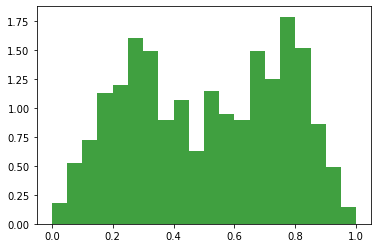

In [200]:
# distribution of labels in the dataset
visualize_labels(train_set)

In [201]:
# select sequence adequat to a specific label in the dataset
pprint(select_sequence_from_label(train_set, 0.9, num_samples=5, epsilon=0.025))

Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-c21093f0820b5c62.arrow


samples from label: 0.9
['Just the labour involved in creating the layered richness of the imagery in '
 'this chiaroscuro of madness and light is astonishing .',
 'Good fun , good action , good acting , good dialogue , good pace , good '
 'cinematography .',
 'Grenier is terrific , bringing an unforced , rapid-fire delivery to Toback '
 "'s Heidegger - and Nietzsche-referencing dialogue .",
 'The wanton slipperiness of \\* Corpus and its amiable jerking and reshaping '
 'of physical time and space would make it a great piece to watch with kids '
 'and use to introduce video as art .',
 'I walked away from this new version of E.T. just as I hoped I would -- with '
 'moist eyes .']
None


### 1.1 Text Cleaning
**Exercise 2**: 
Create a function `tokenize_sentence` that cleans and tokenize the "tokens" column, as follows: 

In [202]:
train_set[np.random.randint(len(train_set))]['tokens']

'A|dark-as-pitch|comedy|that|frequently|veers|into|corny|sentimentality|,|probably|would|not|improve|much|after|a|therapeutic|zap|of|shock|treatment|.'

In [203]:
from nltk.stem import *
from nltk.stem.porter import *
from nltk.corpus import stopwords

In [204]:
def tokenize(dataset):
  def tokenize_sentence(example):
    # Create a new Porter stemmer
    stemmer = PorterStemmer()
    # all letters in lower case and tokenize
    example["tokens"] = example["tokens"].lower().split("|")
    # remove stop words
    example['tokens'] = [w for w in example["tokens"] if w not in set(stopwords.words('english'))]
    # remove punctuation.
    example["tokens"] = [w for w in example["tokens"] if w.isalpha()]
    # apply stemming
    example['tokens'] = [stemmer.stem(tok) for tok in example['tokens']]
    return example
  processed_dataset = dataset.map(tokenize_sentence)
  return processed_dataset

### 1.2 Build Vocabulary

**Exercise 3:**   
Create a function `build_vocab` that manually creates the vocabulary from the dataset. 

In [205]:
def build_vocab(dataset, min_token_count=1, special_tokens={"<PAD>": 0, "<UNK>": 1}):
  token_to_count = {} # count the number of occurence of each token.
  for seq_tokens in dataset["tokens"]: # loop on each token list using dataset['tokens]
    for token in seq_tokens: # loop on each token of a dataset
      if token not in token_to_count: # check whether the token re-occur 
        token_to_count[token] = 0 
      token_to_count[token] += 1

  # order token_to_count from the most frequent to the last one
  token_to_idx = {}
  for token, idx in special_tokens.items():
    token_to_idx[token] = idx
  for token, count in sorted(token_to_count.items()):
    if count >= min_token_count:
      token_to_idx[token] = len(token_to_idx)
  return token_to_idx, token_to_count

The vocabulary is built upon the full dataset (to take in account all words). 
The next code block load the full dataset and build the vocabulary over the dataset.

In [206]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [207]:
train_val_set = load_dataset("sst", split='train+validation+test')
train_val_set = tokenize(train_val_set)
vocab, tokens_to_count = build_vocab(train_val_set)
print("number of words in vocab", len(vocab))
# pprint(vocab)

No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-7c43baacc0f752a3.arrow


number of words in vocab 11647


In [208]:
# 'tokens': ['rock',
#             'destined',
#             'century',
#             'new',
#             'conan',
#             'going',
#             'make',
#             'splash',
#             'even',
#             'greater',
#             'arnold',
#             'schwarzenegger',
#             'van',
#             'damme',
#             'steven',
#             'segal'],                                         


# 'tokens': ['rock',
#             'destin',
#             'centuri',
#             'new',
#             'conan',
#             'go',
#             'make',
#             'splash',
#             'even',
#             'greater',
#             'arnold',
#             'schwarzenegg',
#             'van',
#             'damm',
#             'steven',
#             'segal'],

In [209]:
all_tokens = train_val_set["tokens"]

### 1.5 Visualize most common words
**Exercise 4**: Visualize the 50 most common words of the full dataset (except stop words). 

In [210]:
from nltk.probability import FreqDist
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [211]:
def plot_common_words(all_tokens, remove_stop_words=True):
  if remove_stop_words:
    stop_words = stopwords.words('english')
    flattened_tokens = [w for sent in all_tokens for w in sent if w not in set(stop_words)]
  else:
    flattened_tokens = [w for sent in all_tokens for w in sent]
  # histogram of most common words. 
  fdist = FreqDist(flattened_tokens)
  print(fdist.items())
  fdist1 = fdist.most_common(50)
  fdist1_dict = {key: value for key, value in fdist1}
  fig, ax = plt.subplots(1, 1, figsize=(60, 10))
  ax.set_title("Most common words", fontsize=24)
  ax.bar(fdist1_dict.keys(), fdist1_dict.values())
  # ax.xticks(rotation=45)
  ax.tick_params(axis='x', labelsize=24, labelrotation=45)
  rects = ax.patches
  labels = [rect.get_height() for rect in rects]
  for rect, label in zip(rects, labels):
      height = rect.get_height()
      ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, label,
                  ha='center', va='bottom', fontsize=20)
  ax.legend()

No handles with labels found to put in legend.


dict_items([('rock', 37), ('destin', 19), ('centuri', 22), ('new', 207), ('conan', 2), ('go', 201), ('make', 611), ('splash', 9), ('even', 388), ('greater', 7), ('arnold', 15), ('schwarzenegg', 8), ('van', 12), ('damm', 2), ('steven', 29), ('segal', 1), ('gorgeous', 7), ('elabor', 11), ('continu', 26), ('lord', 5), ('ring', 25), ('trilog', 4), ('huge', 28), ('column', 3), ('word', 49), ('adequ', 10), ('describ', 18), ('peter', 20), ('jackson', 25), ('expand', 9), ('vision', 34), ('tolkien', 3), ('bryan', 2), ('adam', 26), ('contribut', 8), ('slew', 1), ('song', 30), ('potenti', 40), ('hit', 60), ('simpli', 72), ('intrus', 2), ('stori', 536), ('whole', 79), ('packag', 6), ('certainli', 55), ('captur', 56), ('intend', 20), ('er', 3), ('spirit', 65), ('piec', 107), ('think', 129), ('america', 29), ('would', 246), ('enough', 267), ('plucki', 2), ('british', 22), ('eccentr', 23), ('heart', 127), ('gold', 4), ('yet', 125), ('act', 190), ('still', 181), ('charm', 140), ('whether', 52), ('enli

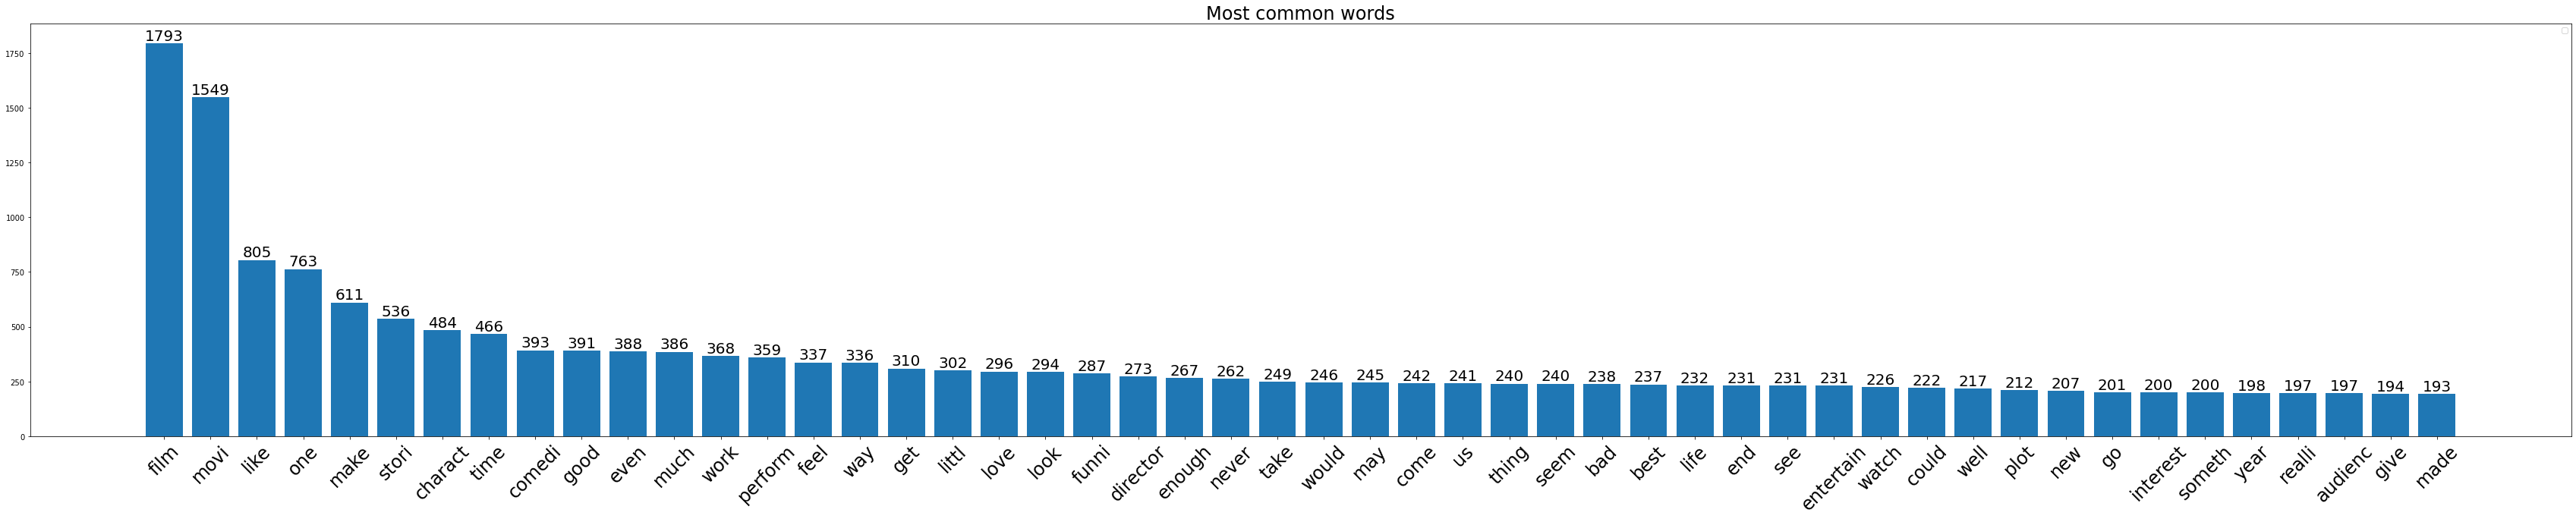

In [212]:
plot_common_words(all_tokens, remove_stop_words=True)

### 1.6 Encode sentences
The next code block creates an `encode` function that convert a sequence of tokens into integers using the vocabulary. 

In [213]:
def encode(seq_tokens, vocab, allow_unk=True):
  seq_idx = []
  for token in seq_tokens:
    if token not in vocab:
      if allow_unk:
        token = '<UNK>'
      else:
        raise KeyError('Token "%s" not in vocab' % token) 
    seq_idx.append(vocab[token])
  return seq_idx

**Exercise 5:**
Use `tensorflow.keras.preprocessing.text.Tokenizer` (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to implement more simply:
1. The construction of the vocabulary using the method `fit_on_texts`
2. The `encode` function using the method `texts_to_sequences
`

In [214]:
# prepare tokenizer
docs = [" ".join(sent) for sent in all_tokens]
t = Tokenizer() # use to build a vocabulary
t.fit_on_texts(docs) # build the vocabulary. 
vocab_size = len(t.word_index) + 1 # for the padding token.
vocab = t.word_index
print("LEN VOCAB:", len(vocab))
vocab["<PAD>"] = 0

LEN VOCAB: 11645


In [215]:
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
##### added 
max_length = len(max(encoded_docs, key=len))
print(max_length)
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
print(f'length of encoded_docs is {len(encoded_docs)}')
print(f'example of encoded sequence : {encoded_docs[0]}')

28
[[  535  1085   932 ...     0     0     0]
 [ 2470  1710   790 ...     0     0     0]
 [ 5348   791  2232 ...     0     0     0]
 ...
 [  406   137     9 ...     0     0     0]
 [   24  1183   560 ...     0     0     0]
 [11644 11645   518 ...     0     0     0]]
length of encoded_docs is 11855
example of encoded sequence : [535, 1085, 932, 42, 5346, 43, 5, 2034, 11, 2469, 1328, 2231, 1601, 5347, 695, 7162]


The next code block processes the dataset by: 
* Encoding each sentence into integers and adding padding. 
* Categorize labels into three categories (positive, negative, neutral). 
* Create a tensorflow dataset with encoded sentence (=input data) and category label (=target)

In [216]:
# get max sequence length
max_len = max([len(sent) for sent in all_tokens])
print("max sentence length", max_len)

max sentence length 28


In [217]:
def process_dataset(dataset, vocab, max_len):
  def process_example(example):
    example["inputs"] = encode(example['tokens'], vocab, allow_unk=False)
    example = binarize_label(example)
    return example
  dataset = tokenize(dataset)
  encoded_dataset = dataset.map(process_example)
  print("encoded_dataset[0]")
  pprint(encoded_dataset[0], compact=True)
  # pad sequences
  padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(encoded_dataset["inputs"], 
                                                                   padding="post", 
                                                                   truncating="post", 
                                                                   maxlen=max_len, 
                                                                   value=0)
  print(padded_sequences.shape)
  tfdataset = tf.data.Dataset.from_tensor_slices((padded_sequences, 
                                                  encoded_dataset["binary_label"]))
  return tfdataset

In [218]:
train_dataset = process_dataset(train_set, vocab, max_len)
val_dataset = process_dataset(val_set, vocab, max_len)
test_dataset = process_dataset(test_set, vocab, max_len)

Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-297e81a4af69cde4.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-fdb3748cffdad499.arrow


encoded_dataset[0]
{'binary_label': 1,
 'inputs': [535, 1085, 932, 42, 5346, 43, 5, 2034, 11, 2469, 1328, 2231, 1601,
            5347, 695, 7162],
 'label': 0.6944400072097778,
 'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' "
             "and that he 's going to make a splash even greater than Arnold "
             'Schwarzenegger , Jean-Claud Van Damme or Steven Segal .',
 'tokens': ['rock', 'destin', 'centuri', 'new', 'conan', 'go', 'make', 'splash',
            'even', 'greater', 'arnold', 'schwarzenegg', 'van', 'damm',
            'steven', 'segal'],
 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0'}


Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-758eb330377b5aa8.arrow


(8544, 28)


Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-4aefac62cd05493c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-9c6aa3c7096a9a0e.arrow


encoded_dataset[0]
{'binary_label': 1,
 'inputs': [19, 1, 19, 14, 1180, 10395],
 'label': 0.791670024394989,
 'sentence': "It 's a lovely film with lovely performances by Buy and Accorsi "
             '.',
 'tokens': ['love', 'film', 'love', 'perform', 'buy', 'accorsi'],
 'tree': '25|23|21|20|20|19|17|17|16|14|14|15|24|15|16|18|18|19|22|21|22|23|24|25|0'}
(1101, 28)


Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-da60c48f064f3e74.arrow


encoded_dataset[0]
{'binary_label': 1,
 'inputs': [19, 1, 19, 14, 1180, 10395],
 'label': 0.791670024394989,
 'sentence': "It 's a lovely film with lovely performances by Buy and Accorsi "
             '.',
 'tokens': ['love', 'film', 'love', 'perform', 'buy', 'accorsi'],
 'tree': '25|23|21|20|20|19|17|17|16|14|14|15|24|15|16|18|18|19|22|21|22|23|24|25|0'}
(1101, 28)


In [219]:
# Create dataloader using batch. 
batch_size = 32
train_dataloader = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
next(iter(train_dataloader)) # used for the dataloader to pass away 
val_dataloader = val_dataset.batch(batch_size=batch_size, drop_remainder=True)
next(iter(val_dataloader))
test_dataloader = test_dataset.batch(batch_size=batch_size, drop_remainder=True)
next(iter(test_dataloader))

(<tf.Tensor: shape=(32, 28), dtype=int32, numpy=
 array([[   19,     1,    19,    14,  1180, 10395,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [    4,   278, 10396,   281,    33,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  251,   135,   921,   633,    97,   466,  1035,   662,  1923,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  549,    21,   185,     1,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  143,   6

## 2. Build RNN Model

In [220]:
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
glove_emb = api.load("glove-wiki-gigaword-50")

In [221]:
def word_embedding_matrix(glove_emb, vocab_size):
  # create a weight matrix for words in training docs
  embedding_matrix = np.zeros((vocab_size, 50))
  ### ----------------------- YOUR CODE HERE --------------------------------------------- ###
  for word,i in vocab.items():
    print(word)
    # check if word belongs to Glove vocabulary 
    if word in glove_emb.vocab.keys():
      embedding_vector = glove_emb.word_vec(word)
      embedding_matrix[i] = embedding_vector
  print('Null word embedding: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))    
  return embedding_matrix

In [222]:
embedding_matrix = word_embedding_matrix(glove_emb, vocab_size)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
unwilling
tux
superman
sloppili
pin
bandera
doa
motif
firebal
groaner
sketchiest
coda
fluke
oblig
asia
insuffici
skid
balkan
groupi
heather
therefor
greenlight
sacr
dislik
ho
adrift
gum
ralli
bid
treacheri
scooter
hectic
mope
lessen
uptight
simul
susten
brawni
soliloqui
spawn
wing
nurs
gape
hangov
overload
glitter
wayn
dodg
videodrom
nike
redon
spinoff
lure
aftertast
tad
jez
butterworth
afterward
neutral
uphil
irksom
complac
demeo
abbott
ernest
filmgoer
chou
laurenc
pawn
hypertim
flavorless
disreput
do
shelv
shiver
grandfath
lazili
ici
wail
wearisom
regular
messeng
trump
tide
slowest
highbrow
threshold
biblic
anarchi
pork
firework
strenuous
transplant
wari
lisa
inhal
copycat
laziest
abrupt
fax
sodden
violat
horizon
shabbi
peculiarli
rey
iq
pubesc
belgian
burk
simplemind
trio
twirl
exclam
whistl
detriment
drone
ganesh
wimp
evangel
erotic
goth
troll
soporif
crassli
woozi
luridli
tutori
referenti
bratti
calib
ni

In [223]:
# # Build Model
# def build_LSTM(seq_len, vocab_size, emb_size, output_size, rnn_units, dropout_rate, rnn_drop_rate=0.4):
#   # Inputs of our LSTM
#   inputs = tf.keras.Input(shape=(seq_len,)) 
#   # Embedding Layer
#   embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True)(inputs) # PADDING IS NOT ACCOUNTED IN LOSS (mask_zero = True)
#   # LSTM Layer
#   hidden = tf.keras.layers.LSTM(rnn_units, recurrent_dropout=rnn_drop_rate)(embedding) # return last hidden state by default. 
#   outputs = tf.keras.layers.Dropout(rate=dropout_rate)(hidden)
#   # Dense Layer - projection over the output size (i.e number of classes.)
#   outputs = tf.keras.layers.Dense(output_size)(outputs)
#   lstm_model = tf.keras.Model(outputs=outputs, inputs=inputs, name='lstm_for_classification')
#   return lstm_model

**Exercise 6:**
Implement the same model using `tensorflow.keras.Sequential` API instead: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

In [240]:
# # define model
# def build_LSTM_2(seq_len , vocab_size, output_size, emb_size, rnn_units, dropout_rate, rnn_drop_rate=0.0):
#   model = Sequential() # keras model
#   model.add(Embedding(input_dim=vocab_size, output_dim=emb_size, weights=[embedding_matrix], input_length=seq_len, trainable=False, mask_zero=True))
#   model.add(Flatten())
#   model.add(tf.keras.layers.LSTM(rnn_units, recurrent_dropout=rnn_drop_rate)) # create LSTM model
#   model.add(Dense(output_size, activation='softmax')) # we compute only logits 
#   return model

In [235]:
# # define model
# def build_LSTM_2(seq_len, vocab_size, emb_size, output_size, rnn_units, dropout_rate, rnn_drop_rate=0.0):
#   model = Sequential() # keras model
#   model.add(Embedding(vocab_size, emb_size, input_length=seq_len, mask_zero=True)) # embedding layer
#   model.add(tf.keras.layers.LSTM(rnn_units, recurrent_dropout=rnn_drop_rate)) # create LSTM model
#   model.add(Dense(output_size, activation='softmax')) # we compute only logits 
#   return model

In [242]:
# define model
def build_LSTM_2(seq_len, vocab_size, emb_size, output_size, rnn_units, dropout_rate, rnn_drop_rate=0.0):
  model = Sequential() # keras model
  model.add(Embedding(vocab_size, emb_size, input_length=seq_len,weights=[embedding_matrix], trainable=False, mask_zero=True)) # embedding layer
  model.add(tf.keras.layers.LSTM(rnn_units, recurrent_dropout=rnn_drop_rate)) # create LSTM model
  model.add(Dense(output_size, activation='softmax')) # we compute only logits 
  return model

## 3. Train the sentiment classifier
**Exercise 6**:  
Create a `train_LSTM` function that trains the lstm model on the train dataset. 
See the following tutorial as an example: https://www.tensorflow.org/guide/keras/train_and_evaluate


In [244]:
maw_len = len(max(encoded_docs, key=len))
lstm_model = build_LSTM_2(seq_len=max_len, vocab_size=len(vocab), emb_size=50, output_size=3, rnn_units=64, dropout_rate=0.4)
lr = 0.001
optimizer = tf.keras.optimizers.Adam(lr,beta_1=0.9,beta_2=0.98,epsilon=1e-9)
EPOCHS = 10

In [245]:
def train_LSTM(model, optimizer, EPOCHS, train_dataset, val_dataset, checkpoint_path):
    # save checkpoints and create callbacks
    LSTM_ckpt_path = checkpoint_path + '/' + 'LSTM-{epoch}'
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=LSTM_ckpt_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            verbose=1)
    ]
    # compile model with optimizer and loss, metrics = "accuracy": 
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"]) 

    print(model.summary())

    # --- starting the training ... -----------------------------------------------
    start_training = time.time()
    # fit the model to the train dataset:
    rnn_history = model.fit(train_dataset,
                            epochs=EPOCHS,
                            validation_data=val_dataset,
                            callbacks=callbacks,
                            verbose=2)
    print('Training time for {} epochs: {}'.format(EPOCHS, time.time() - start_training))
    print('training of a RNN for sentiment analysis done...')
    return rnn_history

In [246]:
import os
import time
checkpoint_path = "/checkpoints"
if not os.path.isdir(checkpoint_path):
  os.makedirs(checkpoint_path)

In [247]:
train_history = train_LSTM(model=lstm_model, 
                           optimizer=optimizer, 
                           EPOCHS=EPOCHS, 
                           train_dataset=train_dataloader, 
                           val_dataset=val_dataloader, 
                           checkpoint_path=checkpoint_path)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 28, 50)            582300    
                                                                 
 lstm_6 (LSTM)               (None, 64)                29440     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 611,935
Trainable params: 29,635
Non-trainable params: 582,300
_________________________________________________________________
None
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)



Epoch 00001: val_loss improved from inf to 1.35838, saving model to /checkpoints/LSTM-1
267/267 - 11s - loss: 0.7892 - accuracy: 0.6982 - val_loss: 1.3584 - val_accuracy: 0.3824 - 11s/epoch - 40ms/step
Epoch 2/10

Epoch 00002: val_loss did not improve from 1.35838
267/267 - 7s - loss: 0.8596 - accuracy: 0.6354 - val_loss: 1.3809 - val_accuracy: 0.3842 - 7s/epoch - 26ms/step
Epoch 3/10

Epoch 00003: val_loss did not improve from 1.35838
267/267 - 5s - loss: 0.8693 - accuracy: 0.6278 - val_loss: 1.3784 - val_accuracy: 0.3860 - 5s/epoch - 18ms/step
Epoch 4/10

Epoch 00004: val_loss did not improve from 1.35838
267/267 - 5s - loss: 0.8748 - accuracy: 0.6224 - val_loss: 1.3820 - val_accuracy: 0.3879 - 5s/epoch - 18ms/step
Epoch 5/10

Epoch 00005: val_loss did not improve from 1.35838
267/267 - 5s - loss: 0.8830 - accuracy: 0.6159 - val_loss: 1.3851 - val_accuracy: 0.3925 - 5s/epoch - 18ms/step
Epoch 6/10

Epoch 00006: val_loss did not improve from 1.35838
267/267 - 5s - loss: 0.8894 - accu

In [248]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

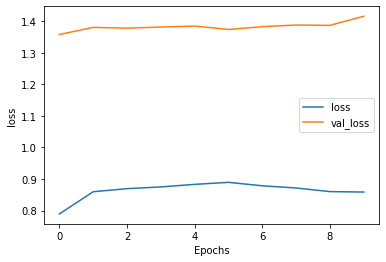

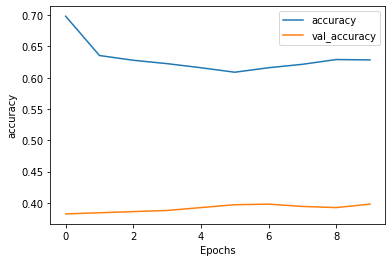

In [249]:
plot_graphs(train_history, "loss")
plot_graphs(train_history, "accuracy")

## 4. Predictions on test dataset

In [ ]:
# with stop words & without stemming
# 34/34 [==============================] - 0s 11ms/step - loss: 6.7488 - accuracy: 0.4789
# Test Loss: 6.748809337615967
# Test Accuracy: 0.4788602888584137


# without stop words & without stemming
# 34/34 [==============================] - 0s 11ms/step - loss: 4.3478 - accuracy: 0.4219
# Test Loss: 4.347785949707031
# Test Accuracy: 0.421875

# without stop words & with stemming
# 34/34 [==============================] - 0s 10ms/step - loss: 2.7644 - accuracy: 0.4688
# Test Loss: 2.7644424438476562
# Test Accuracy: 0.46875

# without stopwords & with stemming & Glove embedding
# 34/34 [==============================] - 0s 10ms/step - loss: 1.4163 - accuracy: 0.3980
# Test Loss: 1.4162859916687012
# Test Accuracy: 0.39797794818878174

In [250]:
test_loss, test_acc = lstm_model.evaluate(test_dataloader)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

34/34 [==============================] - 0s 10ms/step - loss: 1.4163 - accuracy: 0.3980
Test Loss: 1.4162859916687012
Test Accuracy: 0.39797794818878174


In [251]:
import nltk
nltk.download('punkt')
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [253]:
# #predict on a sample text without padding.
# from nltk.tokenize import word_tokenize
# sample_text = 'The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.'
# sample_tokens = sample_text.lower().split()
# sample_tokens = [w for w in sample_tokens if w.isalpha()]

# tokens = word_tokenize(sample_text)
# tokens = [w.lower() for w in tokens]
# re_punc = re.compile('[%s]' % re.escape(string.punctuation))
# stripped = [re_punc.sub('', w) for w in tokens]
# words = [w for w in stripped if w.isalpha()]
# words = [w for w in words if w not in set(stopwords.words('english'))]
# sample_text_encoded = encode(words, vocab, allow_unk=False)
# sample_text_encoded = tf.keras.preprocessing.sequence.pad_sequences([sample_text_encoded], padding="post",
#                                                                      truncating="post", maxlen=max_len, value=0)
# print(sample_text_encoded)

In [254]:
# #predict on a sample text without padding.
# sample_text = 'The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.'
# sample_tokens = sample_text.lower().split()
# sample_tokens = [w for w in sample_tokens if w.isalpha()]
# sample_tokens = tokenize(sample_text)
# sample_text_encoded = encode(sample_tokens, vocab, allow_unk=False)
# sample_text_encoded = tf.keras.preprocessing.sequence.pad_sequences([sample_text_encoded], padding="post",
#                                                                      truncating="post", maxlen=max_len, value=0)
# print(sample_text_encoded)

In [255]:
# sample_text_encoded = tf.constant(sample_text_encoded, dtype=tf.int32)
# predictions = lstm_model.predict(sample_text_encoded)
# predictions_probs = tf.nn.softmax(predictions)
# print(predictions_probs)
# predicted_label  = tf.argmax(predictions_probs, axis=-1)
# print("predicted label {} with probs {}".format(predicted_label, tf.squeeze(predictions_probs)[tf.squeeze(predicted_label).numpy()]))

### Additionnal Exercises. 
Recode Implementation with instead: 
   - several layers of LSTM
   - bi-directionnal LSTM using https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
   - average of hidden states as final hidden representation (instead of last hidden state). 
   - add gradient clipping: https://www.tensorflow.org/api_docs/python/tf/clip_by_norm
   - do hyperparameter-search on model dimensions, training hyper-parameters to reach a better val accuracy. 